#### Udacity Project : Wrangling and analysing Data

### Objectif:
our main goal in this project is to practice and showcase what we learned in the Wrangling and Analyze Data lessons of udacity's Data analysis Nanodegree
For this we will be using the twitter's WeRatedogs archive which is an account that rate people's dogs 


In [265]:
#the necessary imports for the project
import pandas as pd
import numpy as np
import tweepy
import requests
import json
import matplotlib.pyplot as plt
%matplotlib inline

### Gathering the data
we will now gather the data that we will use in this project

we will start with the data that was giving to us anddownload manualy

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

we will now gather data using the request library

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
    
image_predictions  = pd.read_table('image_predictions.tsv', sep='\t')

and now we are going to use the twitter API to gather what we need

In [4]:
#first we connect with our key's to the twitter API
#as required by tweeter policie i am not allowed to share my keys in here
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

now we will load the tweets

In [39]:
# Read tweets via Twitter API
tweets = []

for tweet in twitter_archive['tweet_id']:
    try:
        tweets.append(api.get_status(tweet))
    except tweepy.TweepError as e:
        #we will leave the except empty just to not load the screen a lot
        #we will copy this list to avoid mistakes and having to charge the list again
        pass

Rate limit reached. Sleeping for: 404
Rate limit reached. Sleeping for: 496


this operation takes a lot of time so we will copy the list to avoid mistakes

In [42]:
tweets_backup = tweets.copy()

In [59]:
tweets = tweets_backup.copy()

In [60]:
# Display the number of tweets downloaded
print('Number of tweets successfully downloaded: ', len(tweets))

Number of tweets successfully downloaded:  2328


### Assessing the data

In [44]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [47]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


We can already see that we will not need all the columns (ex : rating_denominator because we know it is always ten),and all the columns doggo...puppu seems to be "None",we will need to try this programmatically

In [61]:
#do not atempt to display the hole list or your browser will crash
tweets[0]

Status(_api=<tweepy.api.API object at 0x00000219CBD694F0>, _json={'created_at': 'Tue Aug 01 16:23:56 +0000 2017', 'id': 892420643555336193, 'id_str': '892420643555336193', 'text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]},

we will need to make the tweets list into a dataframe to have a better visual and to be able to better manipulate it

In [62]:
#we save the list in a txt file
new_tweets = []
for tweet in tweets:
    new_tweets.append(tweet._json)

with open('js_tweet.txt', 'w') as file:
        file.write(json.dumps(new_tweets, indent=4))

In [64]:
#this code have been taken from stack overflow
#link : https://stackoverflow.com/questions/47612822/how-to-create-pandas-dataframe-from-twitter-search-api
#answer of Nikos Tavoularis,the last code have been adabpted to our situation
'''
i choose to just rewrite the old list tweets instend of trasforming 
the old one because i found it to be more conviniente this way,transforming
the old one have proven to be surprisingly difficult

'''
tweet_list = []
with open('js_tweet.txt', encoding='utf-8') as json_file:  
    data_json = json.load(json_file)
    for each_tweet in data_json:
        tweet_id = each_tweet['id']
        whole_tweet = each_tweet['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_tweet['favorite_count']
        retweet_count = each_tweet['retweet_count']
        created_at = each_tweet['created_at']
        whole_source = each_tweet['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_tweet['retweeted_status'] = each_tweet.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        tweet_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'url': url,
                             'created_at': created_at,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        df_tweet = pd.DataFrame(tweet_list, columns = ['tweet_id', 'favorite_count', 
                                                       'retweet_count', 'created_at',
                                                       'source', 'retweeted_status', 'url'])

In [67]:
df_tweet.sample()

,tweet_id,favorite_count,retweet_count,created_at,source,retweeted_status,url
86,875144289856114688,19842,4246,Thu Jun 15 00:13:52 +0000 2017,Twitter for iPhone,Original tweet,https://t.co/wK0pt8Cnck


after using sample in the image_predictions dataframe we can see that some rows have some anomalies,like the denominator of rating being different to 10,some cases where numerator of rating < 10 and some that have >>> 10,while these possibilities might be geniun they will bais the data analysis prosses because they are too large in comparison to the other entries

tweets

In [66]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_id          2328 non-null   object
 1   favorite_count    2328 non-null   int64 
 2   retweet_count     2328 non-null   int64 
 3   created_at        2328 non-null   object
 4   source            2328 non-null   object
 5   retweeted_status  2328 non-null   object
 6   url               2328 non-null   object
dtypes: int64(2), object(5)
memory usage: 127.4+ KB


In [85]:
len(twitter_archive.query("doggo != 'None'"))+len(twitter_archive.query("floofer != 'None'"))+len(twitter_archive.query("floofer != 'None'"))+len(twitter_archive.query("floofer != 'None'"))

127

In [342]:
df_tweet["retweeted_status"].value_counts()

Original tweet       2167
This is a retweet     161
Name: retweeted_status, dtype: int64

In [343]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [344]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


# Assesement

## Quality

- some rows in the twitter_archive table have a rating_numerator < 10
- some rows in the twitter_archive have rating_numerator >> 10
- some rows in the twitter_archive have rating_denominator != 10
- remove the retweets from twitter_archive
- remove columns that are related to retweets from twiiter archive
- remove from the prediction table entries that are not dogs
- we will keep only the p1 columns for simplicity
- rows in the image_predictions dataframe will be renamed because they are defficult to interpret
- remove the retweeted_status from df_tweet


## tidiness

- Combine the 4 dog stage columns into a single column in the twitter_archive dataframe
- join the tables

# Cleaning

before cleaning the data we will make copies of our data to avoid losing them

In [340]:
twitter_archive_backup = twitter_archive.copy()
df_tweet_backup = df_tweet.copy()
image_predictions_backup = image_predictions.copy()

# *** Quality ***

## define
    - remove entries that have rating_numerator < 10
    - remove entries that have rating_numerator >> 10
    - remove entries rating_denominator != 10

# code

In [105]:
twitter_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [138]:
twitter_archive["rating_denominator"].mean()

10.455432937181664

In [152]:
twitter_archive_clean = twitter_archive.query("rating_denominator == 10 and rating_numerator > 10 and rating_numerator < 10*2 ")

## testing

In [154]:
assert len(twitter_archive_clean.query("rating_numerator < 10")) == 0

In [155]:
assert len(twitter_archive_clean.query("rating_numerator > 10*2")) == 0 

In [156]:
assert len(twitter_archive_clean.query("rating_denominator != 10")) == 0 

## define 

remove the retweets by Removing   rows with non-null values in retweeted_status_id column

## code

In [165]:
twitter_archive_clean = twitter_archive_clean.query("retweeted_status_id != retweeted_status_id")

## testing

In [167]:
assert len(twitter_archive_clean[twitter_archive_clean["retweeted_status_id"].isnull()])

## define
    -remove the retweeted related columns from twitter_archive

## code

In [182]:
twitter_archive_clean.drop(columns=["in_reply_to_status_id","in_reply_to_user_id","retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp"],inplace=True)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


## testing 

In [183]:
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

## define

- remove from the prediction table entries that are not dogs

## code

In [187]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [188]:
test = image_predictions.query("p1_dog == True")
#we will only concentrate on p1 since we will remove p2 and p3 related columns

## testing

In [191]:
assert len(image_predictions.query("p1_dog == True") == 0)

## define

we will keep only the p1 columns for simplicity

In [195]:
selected_columns = image_predictions[["jpg_url","img_num","p1","p1_conf"]]

In [197]:
image_predictions_clean = selected_columns.copy()

## testing

In [199]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   jpg_url  2075 non-null   object 
 1   img_num  2075 non-null   int64  
 2   p1       2075 non-null   object 
 3   p1_conf  2075 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 65.0+ KB


In [200]:
image_predictions_clean.head()

,jpg_url,img_num,p1,p1_conf
0,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074
1,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826
2,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461
3,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143
4,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311


## define

rows in the image_predictions dataframe will be renamed because they are defficult to interpret

## code

In [279]:
new_names = ["jpg_url","im","prediction","prediction_confidence"]
image_predictions_clean.rename(columns={"p1" : "prediction","p1_conf" : "prediction_confidence"},inplace= True)

## testing

In [280]:
image_predictions_clean.columns

Index(['jpg_url', 'img_num', 'prediction', 'prediction_confidence'], dtype='object')

## define 
- remove the retweeted_status from df_tweet

## code

In [211]:
temp = df_tweet.copy()
df_tweet_clean = df_tweet.drop(columns= {"retweeted_status"});

## testing

In [212]:
df_tweet_clean.columns

Index(['tweet_id', 'favorite_count', 'retweet_count', 'created_at', 'source',
       'url'],
      dtype='object')

# *** Tidiness ***

## define

Combine the 4 dog stage columns into a single column in the twitter_archive dataframe

## code

In [224]:
twitter_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [235]:
dog = []
index = 0
for e in twitter_archive_clean.iterrows() :
    a = twitter_archive_clean.iloc[index]
    if a['doggo'] != "None":
        dog.append(a['doggo'])
    elif a['floofer'] != "None" :
        dog.append(a['floofer'])
    elif a['pupper'] != "None" :
        dog.append(a['pupper'])
    elif a['puppo'] != "None":
        dog.append(a['puppo'])
    else :
        dog.append("None")
    index = index + 1
    

In [236]:
twitter_archive_clean["dog"] = dog

In [241]:
twitter_archive_clean.drop(columns = {"puppo","pupper","floofer","doggo"},axis= 1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None
...,...,...,...,...,...,...,...,...,...
2307,666826780179869698,2015-11-18 03:54:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 simply brilliant pup https://t.co/V6ZzG4...,https://twitter.com/dog_rates/status/666826780...,12,10,None,None
2324,666421158376562688,2015-11-17 01:02:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",*internally screaming* 12/10 https://t.co/YMcr...,https://twitter.com/dog_rates/status/666421158...,12,10,None,None
2329,666373753744588802,2015-11-16 21:54:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Those are sunglasses and a jean jacket. 11/10 ...,https://twitter.com/dog_rates/status/666373753...,11,10,None,None
2336,666273097616637952,2015-11-16 15:14:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Can take selfies 11/10 https://t.co/ws2AMaNwPW,https://twitter.com/dog_rates/status/666273097...,11,10,None,None


## testing 

In [242]:
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'dog'],
      dtype='object')

# define

- merge the dataframes 

In [244]:
df_tweet_clean

,tweet_id,favorite_count,retweet_count,created_at,source,url
0,892420643555336193,34635,7217,Tue Aug 01 16:23:56 +0000 2017,Twitter for iPhone,https://t.co/MgUWQ76dJU
1,892177421306343426,30008,5413,Tue Aug 01 00:17:27 +0000 2017,Twitter for iPhone,https://t.co/aQFSeaCu9L
2,891815181378084864,22593,3576,Mon Jul 31 00:18:03 +0000 2017,Twitter for iPhone,https://t.co/r0YlrsGCgy
3,891689557279858688,37891,7438,Sun Jul 30 15:58:51 +0000 2017,Twitter for iPhone,https://t.co/tD36da7qLQ
4,891327558926688256,36184,7981,Sat Jul 29 16:00:24 +0000 2017,Twitter for iPhone,https://t.co/0g0KMIVXZ3
...,...,...,...,...,...,...
2323,666049248165822465,92,37,Mon Nov 16 00:24:50 +0000 2015,Twitter for iPhone,https://t.co/4B7cOc1EDq
2324,666044226329800704,253,119,Mon Nov 16 00:04:52 +0000 2015,Twitter for iPhone,https://t.co/DWnyCjf2mx
2325,666033412701032449,104,38,Sun Nov 15 23:21:54 +0000 2015,Twitter for iPhone,https://t.co/y671yMhoiR
2326,666029285002620928,116,41,Sun Nov 15 23:05:30 +0000 2015,Twitter for iPhone,https://t.co/r7mOb2m0UI


## code

In [281]:
result_final = pd.concat([df_tweet_clean, image_predictions_clean,twitter_archive_clean], axis=1).reindex(twitter_archive_clean.index)

# testing

In [282]:
assert len(result_final.columns)-len(df_tweet_clean.columns)-len(image_predictions_clean.columns)-len(twitter_archive_clean.columns) == 0

we now will store the data in a csv file

# Storing the data

In [283]:
result_final.to_csv("twitter_archive_master.csv",encoding='utf-8')

# insights and visualisation

In [284]:
result_final.columns

Index(['tweet_id', 'favorite_count', 'retweet_count', 'created_at', 'source',
       'url', 'jpg_url', 'img_num', 'prediction', 'prediction_confidence',
       'tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'dog'],
      dtype='object')

let's start with some histograms

let's see how confident is the neural network that have been used

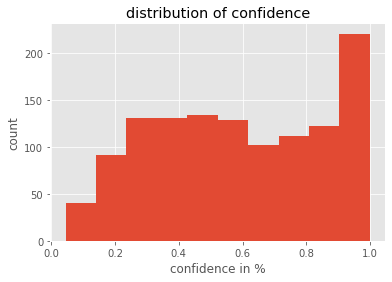

In [289]:
plt.hist(result_final["prediction_confidence"])
plt.style.use('ggplot')
plt.title("distribution of confidence")
plt.xlabel("confidence in %")
plt.ylabel("count")
plt.show()

let's calculate the ratio of entries that have a confidence > to 0.8

In [286]:
ratio = len(result_final.query("prediction_confidence > 0.8"))/len(result_final)

In [287]:
ratio

0.2826938136256852

we can see that almost 30% of the entries have a confidance of above 0.8

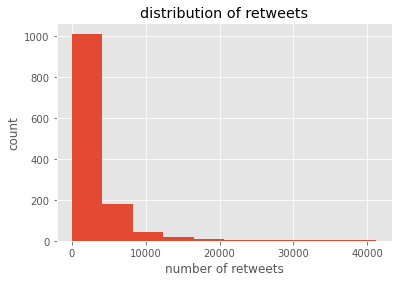

In [291]:
plt.hist(result_final["retweet_count"])
plt.style.use('ggplot')
plt.title("distribution of retweets")
plt.xlabel("number of retweets")
plt.ylabel("count")
plt.show()

In [303]:
test = result_final["dog"].value_counts()
test

None       1043
pupper      132
doggo        74
puppo        20
floofer       8
Name: dog, dtype: int64

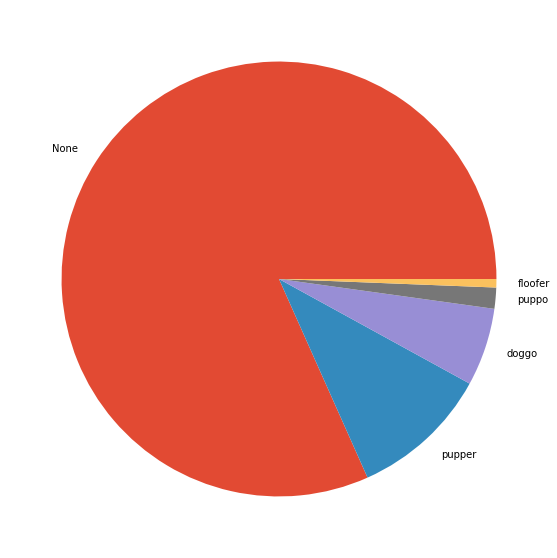

In [306]:
mylabels = ["None", "pupper", "doggo", "puppo","floofer"]
plt.figure(figsize=(10,10))
plt.pie(test, labels = mylabels)
plt.show() 

let's ignore the None entries

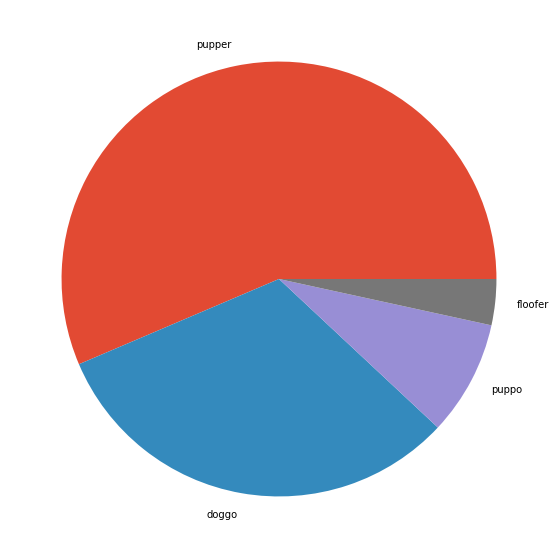

In [307]:
mylabels = [ "pupper", "doggo", "puppo","floofer"]
plt.figure(figsize=(10,10))
plt.pie(test[1:], labels = mylabels)
plt.show() 

we can see that the pupper is dominant in the dataset 

In [309]:
result_final.columns

Index(['tweet_id', 'favorite_count', 'retweet_count', 'created_at', 'source',
       'url', 'jpg_url', 'img_num', 'prediction', 'prediction_confidence',
       'tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'dog'],
      dtype='object')

In [311]:
result_final["rating_numerator"].mean()

11.981205951448707

In [313]:
result_final["rating_numerator"].median()

12.0

we observe that the mean is < to the median,it might be skewed

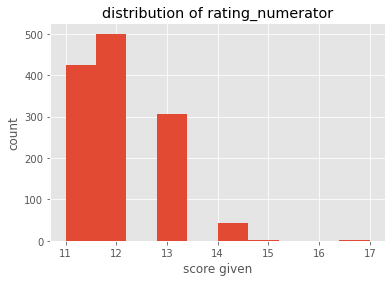

In [348]:
plt.hist(result_final["rating_numerator"])
plt.style.use('ggplot')
plt.title("distribution of rating_numerator")
plt.xlabel("score given")
plt.ylabel("count")
plt.show()

In [337]:
result_final["prediction"].value_counts()

golden_retriever      79
Chihuahua             58
Labrador_retriever    52
Pembroke              47
pug                   40
                      ..
terrapin               1
koala                  1
lorikeet               1
bookcase               1
goose                  1
Name: prediction, Length: 294, dtype: int64

the most popular dogs according to the prediction is the golden_retriever